In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_feature_correlations(X):
    corrmat = X.corr()
    top_corr_features = corrmat.index
    sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [3]:
def plot_feature_scatters(data):
    color_list = ['red' if i=='Abnormal' else 'green' for i in data.loc[:,'class']]

    # s - marker size
    # 
    pd.plotting.scatter_matrix(data.loc[:, data.columns != 'class'],
                                        c=color_list,
                                        figsize= [15,15],
                                        diagonal='hist',
                                        alpha=0.5,
                                        s = 100,
                                        marker = '*',
                                        edgecolor= "black")
    plt.show()

In [4]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, normalize=True):
        self.is_normalize = normalize

    def fit(self, X, y, alpha, num_iters, epsilon):

        # X transformations
        if self.is_normalize == True:
            self.X_, self.mean, self.std = self._normalize(X)
        else:
            self.X_ = X
        self.X_ = self.X_.T
 
        # Y transformations
        encoder = OneHotEncoder()
        encoder.fit(y)
        Y = encoder.transform(y).toarray()
        self.y_labels = [x[3:] for x in  encoder.get_feature_names()]
        self.y_ = Y.T

        self.w = np.full(( self.X_.shape[0],1),0.0)
        self.b = 0.0
        self.w, self.b, self.Js = self._gradient_descent(self.X_, self.y_, self.w, self.b, alpha, num_iters, epsilon, False)
        self.coef_ = self.w

    def predict(self, X, full_output=False):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.is_normalize:
            X_norm = (X - self.mean) / self.std
            z = self._sigmoid(np.dot(self.w.T,X_norm.T)+self.b)
        else:
            z = self._sigmoid(np.dot(self.w.T,X.T)+self.b)
    
        if full_output == True:
            y_pred = np.full((z.shape[1]), {})
            for i in range(z.shape[1]):
                y_pred[i] = { self.y_labels[j]: z[j][i] for j in range(z.shape[0])}
        else:
            y_pred = np.zeros(z.shape[1], dtype=int)
            for i in range(z.shape[1]):
                y_pred[i] = np.argmax(z[:, i])
        return y_pred

    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def _normalize(self, X):
        mean = np.zeros([X.shape[1]])
        std  = np.ones([X.shape[1]])
        
        for i in range(X.shape[1]):
            if (np.std(X.iloc[:, i]) != 0):
                mean[i] = np.mean(X.iloc[:, i])
                std[i] = np.std(X.iloc[:, i])
        X_new = (X - mean) / std
        return X_new, mean, std

    def _cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None

        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _forward_backward_propagation(self, X, Y, w, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(w.T,X) + b
        A = self._sigmoid(z)
        cost = self._cost_function(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)

        return cost, derivative_weights, derivative_bias

    def _gradient_descent(self, X, Y, w, b, alpha, num_iters, epsilon, print_J=False):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]

        J_history = []

        for i in range(num_iters):
            J, delta_weights, delta_bias = self._forward_backward_propagation(X, Y, w, b)

            w = w - alpha * delta_weights
            b = b - alpha * delta_bias

            if print_J == True and i % 100 == 0:
                print(J)

            J_history.append(J)

        return w, b, J_history

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class AttackFGSM():
    # Fast Gradient Sign Method Attack
    def __init__(self, normalize=False):
        self.goal_assurance_history = []

    def fit(self, X, w, b, y, alpha, max_iters, predict_func):
        # Check that X and y have correct shape
        self.w = w
        self.b = b

        self.y_ = np.expand_dims(y.T, axis=1)
        self.X_ = X.T
      
        self.num_iters = 0
        self.X_ = self._gradient_descent(self.X_, self.y_, self.w, self.b, alpha, max_iters, predict_func)

    def _cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None

        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _forward_backward_propagation(self, X, Y, w, b):        
        # forward propagation
        m = X.shape[1]
        z = np.dot(w.T,X) + b
        A = self._sigmoid(z)

        # backward propagation
        dz = A - Y
        
        derivative_x = (1 / m) * np.dot(w, dz)
        return derivative_x

    def _is_tricked(self, X, Y, predict_func):
        # goal class position
        for i in range(Y.shape[1]):
            goal_pos = np.argmax(Y[:, i] != 0)
            if (predict_func(np.array(X))[i] != goal_pos):
                return False
        return True

    def _gradient_descent(self, X, Y, w, b, alpha, max_iters, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        while (not self._is_tricked(X.T, Y, predict_func)) and (self.num_iters <= max_iters):
            delta_x = self._forward_backward_propagation(X, Y, w, b)

            X = X - alpha * np.sign(delta_x)
            self.num_iters += 1       

        # Antitranspose before return
        return X.T

In [7]:
filename = "biomechanical-features-of-orthopedic-patients/column_3C_weka.csv"

train_features = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "degree_spondylolisthesis"]
target_feature = ["class"]
# Spondylolisthesis Hernia Normal

data_features = train_features + target_feature
df = pd.read_csv(filename, delimiter=',')
df = df[data_features]

X, y = df[train_features], df[target_feature]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(310, 6), y=(310, 1)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [9]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64


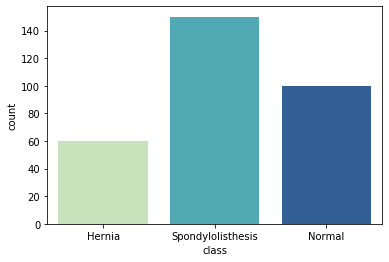

In [10]:
print(df["class"].value_counts())
sns.countplot(x="class", data=df, palette="YlGnBu")
plt.show()

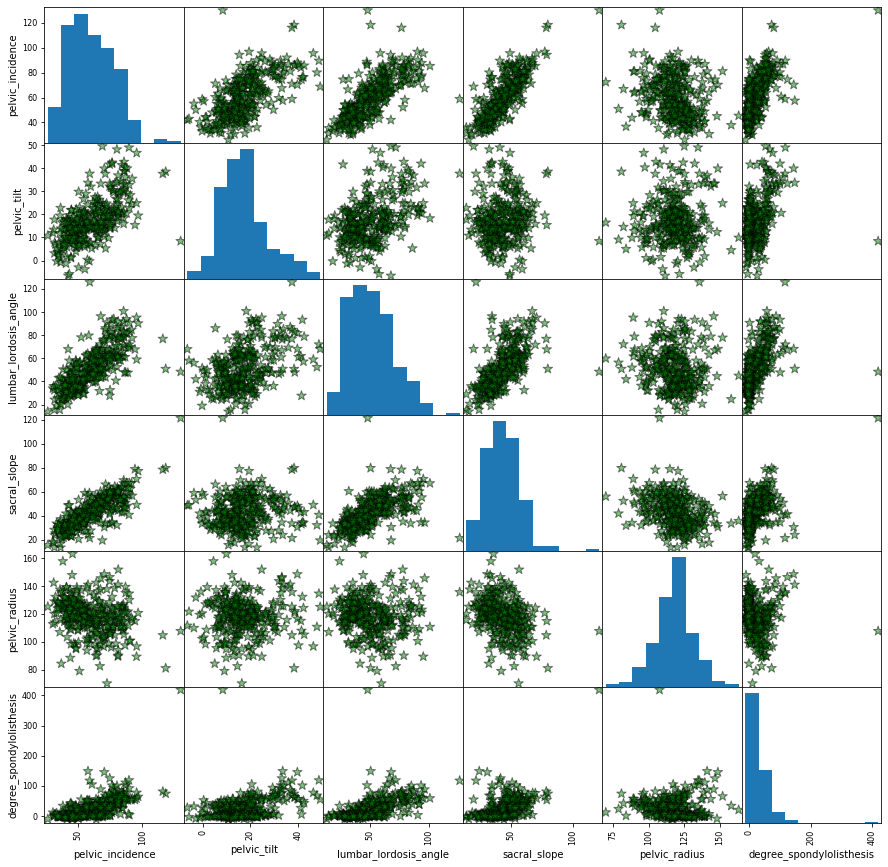

In [11]:
plot_feature_scatters(df)

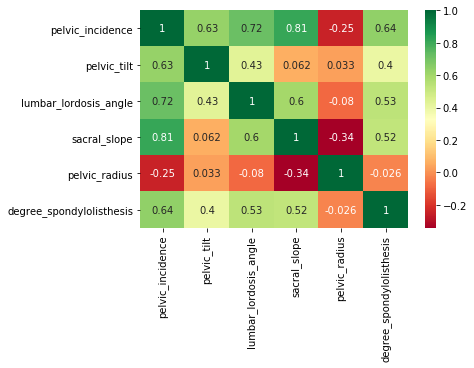

In [12]:
plot_feature_correlations(df)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(248, 6), y=(248, 1)
Test set: X=(62, 6), y=(62, 1)


39.90644033205621


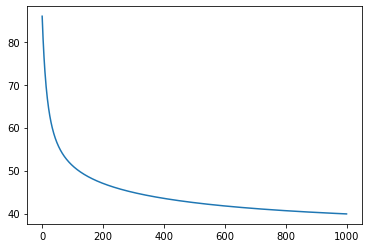

In [14]:
lg = LogisticRegression(normalize=True)
lg.fit(X_train, y_train, 0.05, 1000, 1e-20)

print(lg.get_cost_history()[-1])
plot_J(lg.get_cost_history())

In [15]:
y_pred = [lg.y_labels[idx] for idx in lg.predict(X_test)]

========================== Adversarial Example ==========================
Iterations: 673; alpha: 0.1;
========================== Original =====================================
Pprediction: Spondylolisthesis
[[65.01377322  9.83826237 57.73583722 55.17551084 94.73852542 49.69695462]]
========================== Adversarial ==================================
Prediction: Normal
[[ 22.51377322  46.13826238  -4.76416278  12.87551084 162.03852542
  -17.60304538]]
========================== Difference ===================================
Delta: [[ 42.5 -36.3  62.5  42.3 -67.3  67.3]]


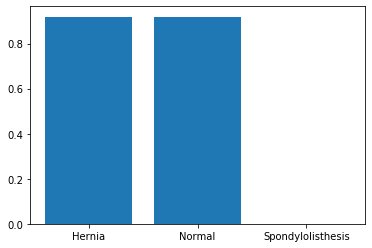

In [16]:

attack = AttackFGSM()

sample_idx = 1
x = np.expand_dims(X_test.iloc[sample_idx, :], axis=0)
goal = np.zeros(np.unique(y_test["class"]).shape)
goal[1] = 1
alpha = 0.1
#x = np.random.random(len(X_test.iloc[8, :]))
attack.fit(x, lg.coef_, lg.b, goal, alpha, 1000, lg.predict)

print("========================== Adversarial Example ==========================")
print(f"Iterations: {attack.num_iters}; alpha: {alpha};")
print("========================== Original =====================================")
print(f"Pprediction: {lg.y_labels[ lg.predict(x)[0]]}")
print(x)
print("========================== Adversarial ==================================")
print(f"Prediction: {lg.y_labels[lg.predict(attack.X_)[0]]}")
print(attack.X_)
print("========================== Difference ===================================")
print(f"Delta: {x - attack.X_}")
print("=========================================================================")

pred_full = lg.predict(attack.X_, full_output=True)
plt.bar(pred_full[0].keys(), pred_full[0].values())
plot_J(attack.goal_assurance_history)
plt.show()

In [17]:
y_real = y_test.iloc[:, 0]
comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
print(comp.head(30))

                y_pred             y_real
130             Hernia  Spondylolisthesis
106  Spondylolisthesis  Spondylolisthesis
139  Spondylolisthesis  Spondylolisthesis
72   Spondylolisthesis  Spondylolisthesis
163  Spondylolisthesis  Spondylolisthesis
61   Spondylolisthesis  Spondylolisthesis
43              Normal             Hernia
204             Hernia  Spondylolisthesis
236             Normal             Normal
210             Hernia             Normal
173             Hernia  Spondylolisthesis
301  Spondylolisthesis             Normal
224  Spondylolisthesis             Normal
227             Normal             Normal
78   Spondylolisthesis  Spondylolisthesis
186  Spondylolisthesis  Spondylolisthesis
21              Normal             Hernia
209             Hernia  Spondylolisthesis
275             Normal             Normal
30              Hernia             Hernia
52              Hernia             Hernia
125  Spondylolisthesis  Spondylolisthesis
266             Normal            

========================== Adversarial Example ==========================
Iterations: 249; alpha: 0.01;
========================== Original =====================================
Pprediction: Normal
[[ 66.28539377  26.32784484  47.49999999  39.95754893 121.2196839
   -0.79962447]]
========================== Adversarial ==================================
Prediction: Hernia
[[ 63.79539377  28.81784484  45.00999999  37.46754893 118.7296839
   -3.28962447]]
========================== Difference ===================================
Delta: [[ 2.49 -2.49  2.49  2.49  2.49  2.49]]


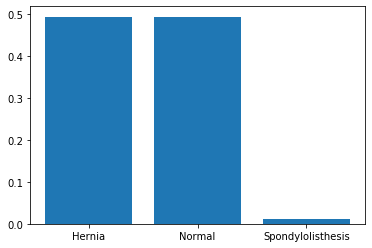

In [18]:
attack = AttackFGSM()

sample_idx = 6
x = np.expand_dims(X_test.iloc[sample_idx, :], axis=0)
goal = np.zeros(np.unique(y_test["class"]).shape)
goal[0] = 1
alpha = 0.01

attack.fit(x, lg.coef_, lg.b, goal, alpha, 1000, lg.predict)

print("========================== Adversarial Example ==========================")
print(f"Iterations: {attack.num_iters}; alpha: {alpha};")
print("========================== Original =====================================")
print(f"Pprediction: {lg.y_labels[ lg.predict(x)[0]]}")
print(x)
print("========================== Adversarial ==================================")
print(f"Prediction: {lg.y_labels[lg.predict(attack.X_)[0]]}")
print(attack.X_)
print("========================== Difference ===================================")
print(f"Delta: {x - attack.X_}")
print("=========================================================================")

pred_full = lg.predict(attack.X_, full_output=True)
plt.bar(pred_full[0].keys(), pred_full[0].values())
plot_J(attack.goal_assurance_history)
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

accuracy = sum(y_real == y_pred) / len(y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7741935483870968
